In [8]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


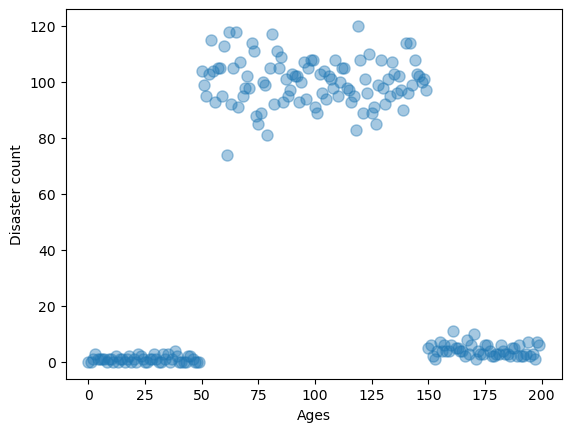

In [4]:
# fmt: off
from numpy import random 

data1 = random.poisson(lam = 1, size = 50)
data2 = random.poisson(lam = 100, size = 100)
data3 = random.poisson(lam = 5, size = 50)

zircons_data = np.concatenate([data1,data2,data3])
ages_nominal = np.arange(0, 200)

plt.plot(ages_nominal, zircons_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Ages");

In [33]:
#k=2 , n=200
#读取用来查的表switchPointList

switchPointList = []

import csv

f = open('2_200.csv', 'r')

with f:

    reader = csv.reader(f)

    for row in reader:
        temp = []
        for e in row:
            temp.append(int(e)) 
        if(temp != []):
            switchPointList.append(temp)
            
random.shuffle(switchPointList)
#print(switchPointList[0])
print(switchPointList)

[[90, 112], [25, 105], [98, 115], [56, 71], [54, 104], [9, 153], [24, 144], [2, 76], [165, 176], [6, 62], [57, 108], [24, 81], [132, 182], [54, 164], [34, 75], [75, 173], [105, 168], [74, 92], [158, 170], [161, 185], [41, 146], [110, 176], [132, 148], [38, 136], [6, 99], [144, 148], [7, 81], [86, 181], [74, 139], [118, 144], [27, 47], [108, 144], [31, 106], [16, 58], [72, 162], [106, 154], [10, 153], [130, 156], [84, 180], [33, 135], [29, 73], [112, 139], [47, 119], [39, 180], [45, 73], [58, 126], [21, 90], [65, 189], [63, 114], [69, 181], [100, 168], [104, 159], [50, 139], [160, 199], [16, 31], [50, 167], [50, 108], [69, 171], [45, 180], [40, 181], [149, 192], [175, 192], [45, 171], [36, 55], [55, 193], [29, 122], [37, 183], [8, 127], [96, 153], [81, 149], [1, 147], [105, 185], [10, 195], [46, 117], [138, 200], [99, 127], [31, 71], [39, 129], [118, 141], [23, 26], [59, 119], [53, 142], [32, 196], [11, 94], [21, 59], [88, 156], [160, 187], [126, 194], [127, 165], [132, 154], [39, 113],

In [34]:
from pytensor.compile.ops import as_op
import pytensor.tensor as at

@as_op(itypes=[at.lscalar, at.dvector], otypes=[at.dvector])
def rate_(index, rates):
    rate = np.zeros(len(ages_nominal))
    
    switchPoints = switchPointList[index]
    
    rate[:switchPoints[0]] = rates[0]
    rate[switchPoints[0]:switchPoints[1]] = rates[1]
    rate[switchPoints[1]:] = rates[2]
    return rate

In [35]:
with pm.Model() as zircons_model:
    
    k = 2
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    

    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    
    index = pm.DiscreteUniform("index", lower = 0, upper = len(switchPointList))
    rates = pm.Exponential("rates",1.0,shape = k+1)
    rate = rate_(index, rates)
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    #rate = rates[0]
    #for i in range(k):
        #rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
        
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24316\1564850345.py:15: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  tr = pm.sample(tune = 3000, draws = 3000, start =start, step=[step1, step2],cores = 1)
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rates]
>Metropolis: [index]


E:\anaconda\envs\pymc_env\Lib\site-packages\pymc\step_methods\metropolis.py:284: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


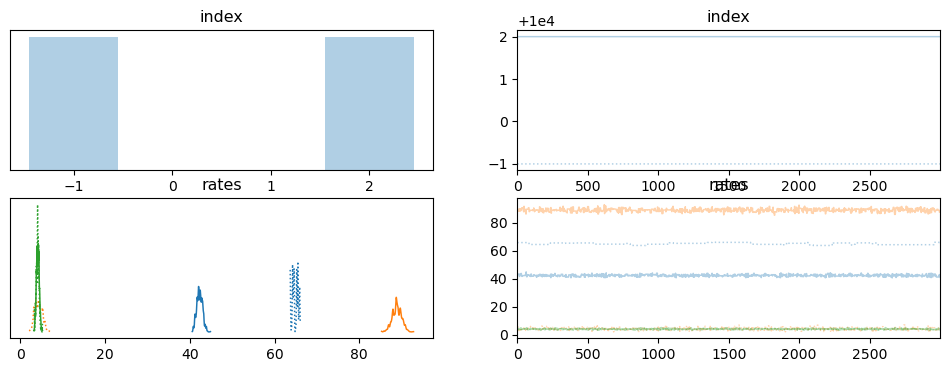

In [45]:
with zircons_model:
    #idata = pm.sample(10000)
    
    # Use slice sampler for means
    step1 = pm.Metropolis([rates])
    # Use Metropolis for switchpoint, since it accommodates discrete variables
    step2 = pm.Metropolis([index])

    # Initial values for stochastic nodes
    start = {"rates": (2.0 , 2.0 , 2.0)}
    start = {"index": 10000}

    #tr = pm.sample(1000, tune=500, start=start, step=[step1, step2], cores=1)
    #tr = pm.sample(start=start, step=[step1, step2],cores = 1)
    tr = pm.sample(tune = 3000, draws = 3000, start =start, step=[step1, step2],cores = 1)
    #az.plot_trace(tr)
    az.plot_trace(tr)

In [37]:
az.summary(tr)

E:\anaconda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,9949.000,4.001,9945.000,9953.000,2.818,2.384,2.0,2.0,7.007070e+15
rates[0],0.927,0.224,0.539,1.359,0.081,0.059,8.0,151.0,1.190000e+00
rates[1],76.870,6.067,70.130,84.711,4.213,3.542,3.0,99.0,1.960000e+00
rates[2],29.791,25.633,3.490,56.899,18.046,15.263,3.0,23.0,1.850000e+00


In [46]:
print(switchPointList[9949])

[30, 128]
